In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [63]:
df = pd.read_csv("./data/fake_news_data.csv")

In [64]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [65]:
unique_domains = list(df["source_domain"].unique())
unique_titles = list(df["title"].unique())

In [66]:
num_words=10000
num_domains = len(unique_domains)

In [72]:

title_input = keras.Input(shape=(1,), name="title", dtype=tf.string)
source_domain_input = keras.Input(shape=(1,), name="domain", dtype=tf.string)
tweet_num_input = keras.Input(shape=(1,), name="num_tweets", dtype=tf.float32)

title_vectorizer = keras.layers.TextVectorization(max_tokens=num_words)
title_vectorizer.adapt(unique_titles)
title_vectorizer=title_vectorizer(title_input)


source_domain_lookup = keras.layers.StringLookup(vocabulary=unique_domains)(source_domain_input)

In [73]:
title_embedding=keras.layers.Embedding(num_words+1, 64)(title_vectorizer)
source_domain_embedding = keras.layers.Embedding(num_domains+1, 64)(source_domain_lookup)


In [74]:
title_features = keras.layers.LSTM(128)(title_embedding)
source_domain_features = keras.layers.GlobalAveragePooling1D()(source_domain_embedding)

In [75]:
x = keras.layers.concatenate([title_features, source_domain_features, tweet_num_input])

In [76]:
output = keras.layers.Dense(1, name="real", activation="sigmoid")(x)

In [77]:
model = keras.Model(inputs=[title_input, source_domain_input, tweet_num_input], outputs=[output])

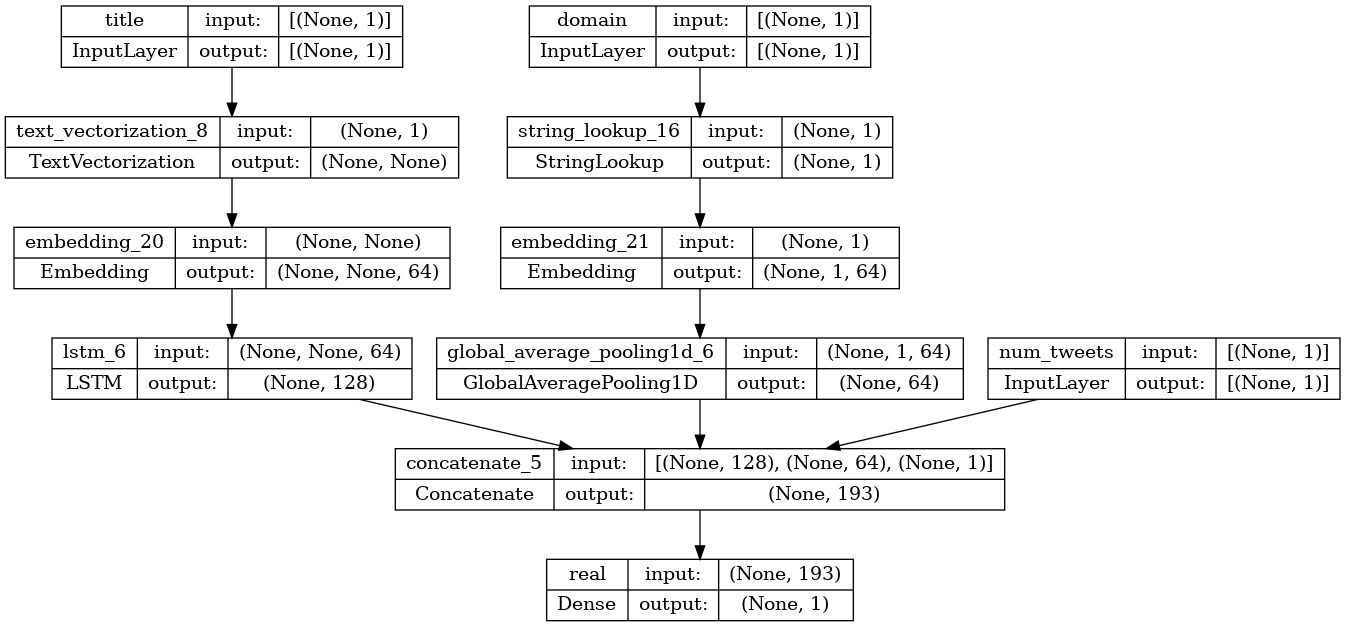

In [78]:
keras.utils.plot_model(model, show_shapes=True)

In [79]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["binary_accuracy"]
)

In [80]:
import numpy as np

In [81]:
title_data = np.array((df["title"].astype(str)))
domain_data = np.array(df["source_domain"].astype(str))
tweet_num_data = np.array(df["tweet_num"])

target = np.array(df["real"].astype(int))

In [82]:
history = model.fit({"title":title_data, 
            "domain":domain_data,
            "num_tweets":tweet_num_data},
            {"real":target}, 
            epochs=15)

Epoch 1/15
725/725 [==============================] - 23s 29ms/step - loss: 1.1872 - binary_accuracy: 0.8069
Epoch 2/15
725/725 [==============================] - 21s 30ms/step - loss: 0.3243 - binary_accuracy: 0.8795
Epoch 3/15
725/725 [==============================] - 21s 29ms/step - loss: 0.3035 - binary_accuracy: 0.8832
Epoch 4/15
725/725 [==============================] - 20s 28ms/step - loss: 0.2883 - binary_accuracy: 0.8910
Epoch 5/15
725/725 [==============================] - 21s 29ms/step - loss: 0.2820 - binary_accuracy: 0.8952
Epoch 6/15
219/725 [========>.....................] - ETA: 16s - loss: 0.2767 - binary_accuracy: 0.8954

In [ ]:
df_samples = df.sample(n=10)
sample_titles = np.array(df_samples["title"])
sample_domains = np.array(df_samples["source_domain"])

In [ ]:
input_example = {
    "title":sample_titles,
    "domain":sample_domains
}

In [ ]:
predictions = model.predict(input_example)

1/1 [==============================] - 1s 1s/step


In [ ]:
print("Predictions", ["real" if pred >= .5 else "fake" for pred in predictions])
print("Actual", ["real" if target == 1 else "fake" for target in df_samples["real"]])


Predictions ['real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'real']
Actual ['real', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real', 'real']
